In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.5.3
1.2.2
0.13.5


# 종목 1 : SAMSUNG

# STEP1 : 시계열 데이터 준비

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

file_path = './005930.KS.csv'
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


Time Series 생성

In [3]:
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행 

결측치 처리

In [4]:
ts = ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

시계열의 안정성 여부 시각화를 통해 확인

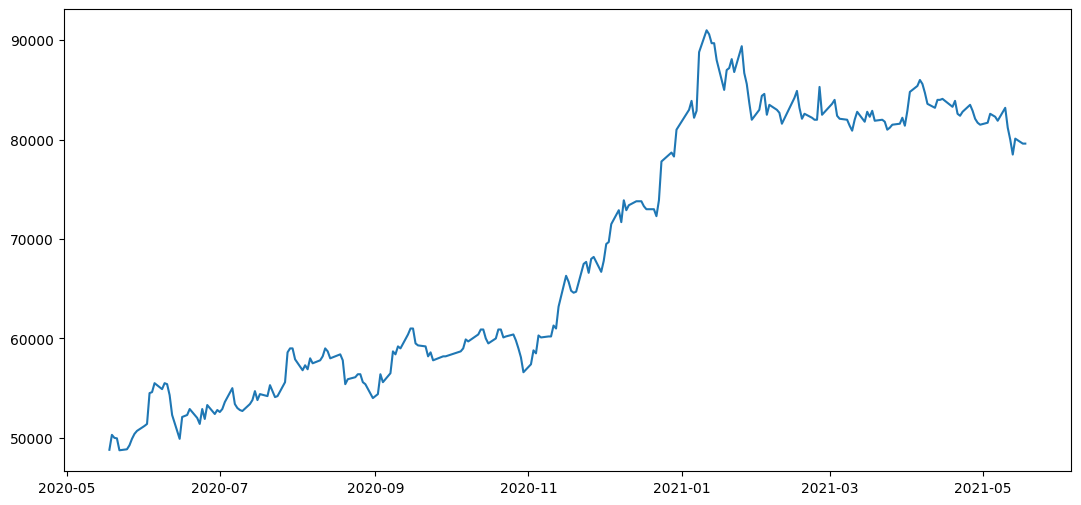

In [5]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기를 13, 6으로 지정
rcParams['figure.figsize'] = 13, 6

# 시계열 데이터를 차트로 시각화
plt.plot(ts)

시간 추이에 따른 일정한 평균, 분산 패턴은 위 그래프 상으로는 보이지 않음

로그 변환

In [6]:
ts_log = np.log(ts)

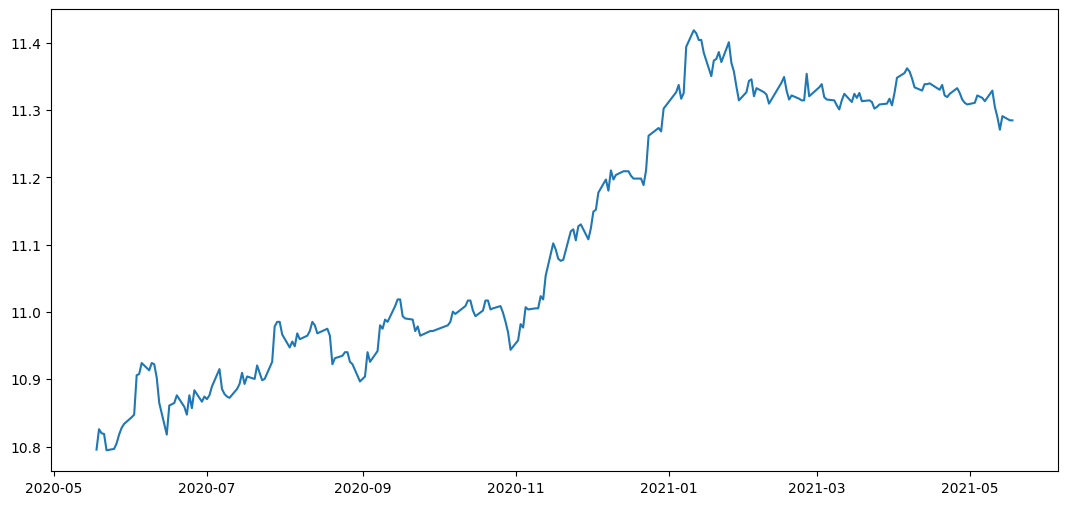

In [7]:
plt.plot(ts_log)

In [8]:
type(ts_log)

pandas.core.series.Series

# STEP 3 : 시계열 안정성 분석

* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

__3.1 정성적 그래프 분석__

그래프 분석을 위한 구간 통계치(Rolling Statistics) 시각화 함수 구현

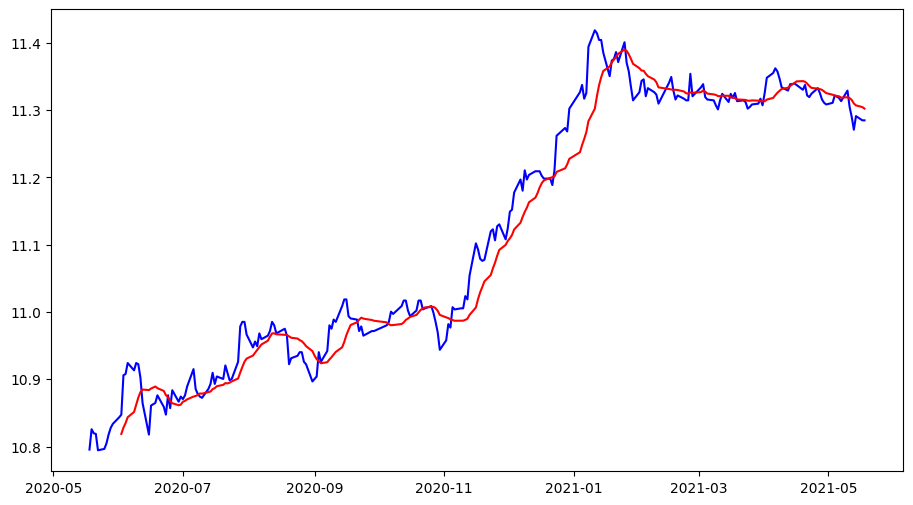

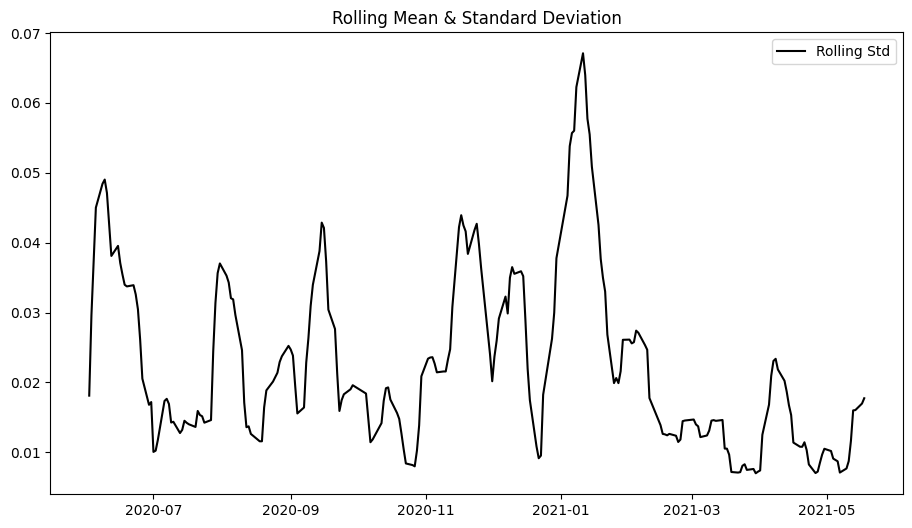

In [15]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균
    rolstd = timeseries.rolling(window=window).std()   # 이동표준편차
    
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color='red', label="Rolling Mean")
    plt.show(block=False)
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

__3.2 정량적 Augmented Dicky-Fuller Test__[참고문헌](https://hongl.tistory.com/98)

시계열에 대해 ADF Test를 수행한 후, 결과값으로 나오는 p-value를 통해 정량적으로 stationary한 데이터인지 (0 에 수렴), non-stationary한 데이터인지 확인 (1에 수렴)

In [17]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # ADF test 결과는 리스트와 딕셔너리 타입이 포함된 tuple형태로 나옴.
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 
                                            'Number of Observatilns Used'])
    
    # dftest의 다섯 번째 요소는 dict 타입으로 저장되어 있음. key, value로 나누어 출력
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observatilns Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value값이 너무 높아 stationary한 시계열이라 볼 수 없음

__3.3 시계열 분해(Time Series Decomposition)__

시계열 안에 존재하는 __trend, seasonality__ 분리해주는 seasonal decompose 메서드 활용

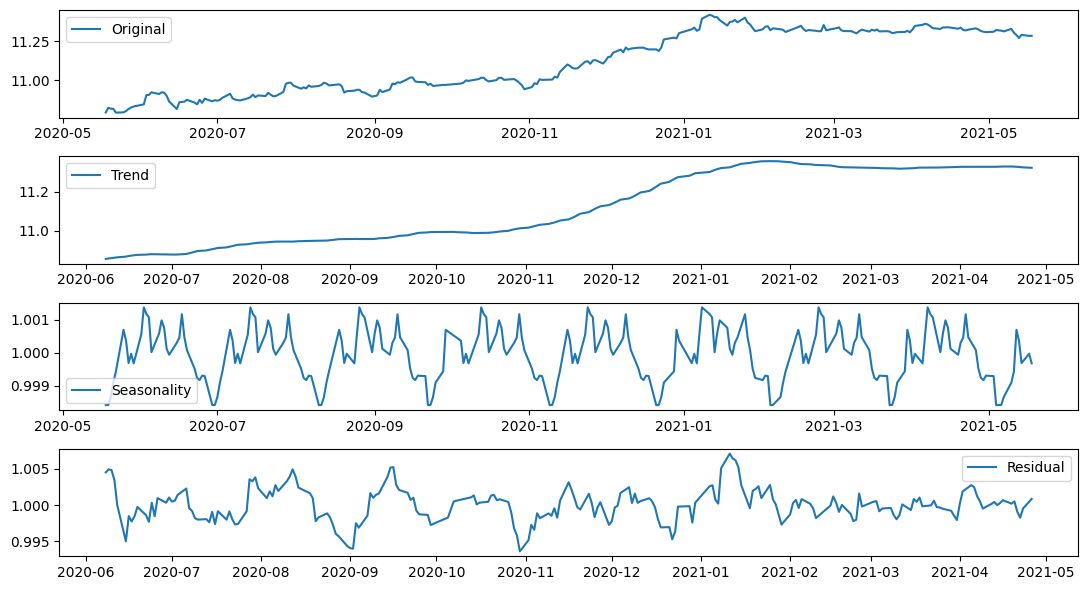

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend # 시간 추이에 따라 나타나는 평균값 변화
seasonality = decomposition.seasonal # 패턴이 파악되지 않은 주기적 변화
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

pattern이 파악되지 않은 주기적 변화라는게 정확히 뭘까? 말이 너무 모순적인데

__3.4 Residual 안정성 확인__

In [27]:
print(residual.isna().sum())

30


In [26]:
residual.shape

(250,)

250개의 행 중, 30개가 결측치를 가짐

In [28]:
residual.dropna(inplace=True)
residual.shape

(220,)

In [29]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observatilns Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


시계열에서 Trend와 Seasonality를 뺀 Residual의 p값은 매우 작아 stationary 하다고 할 수 있음.

# STEP 4 : 학습, 테스트 데이터셋 생성

In [34]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

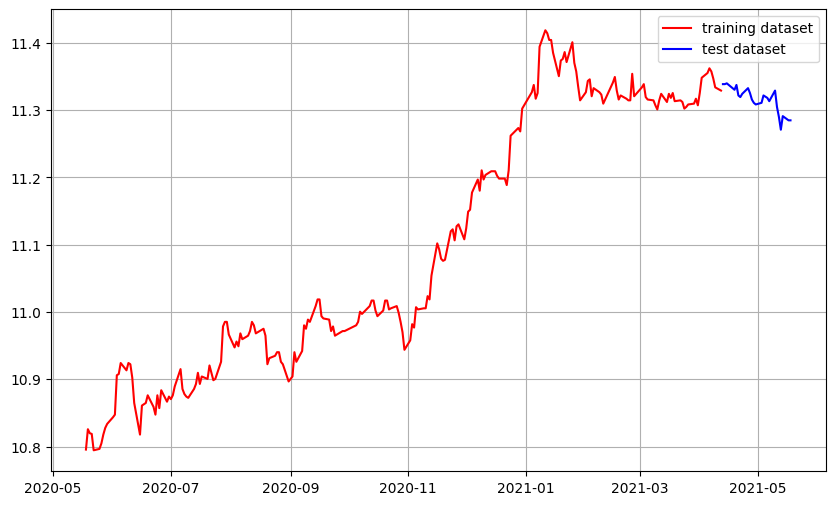

In [37]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r',label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 모수 찾기

ACF, PACF 그려서 p,q 구하기

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


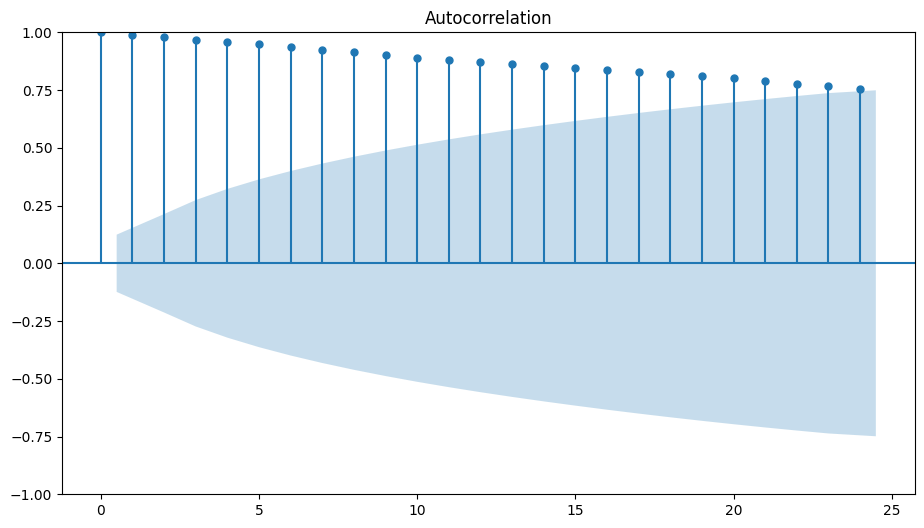

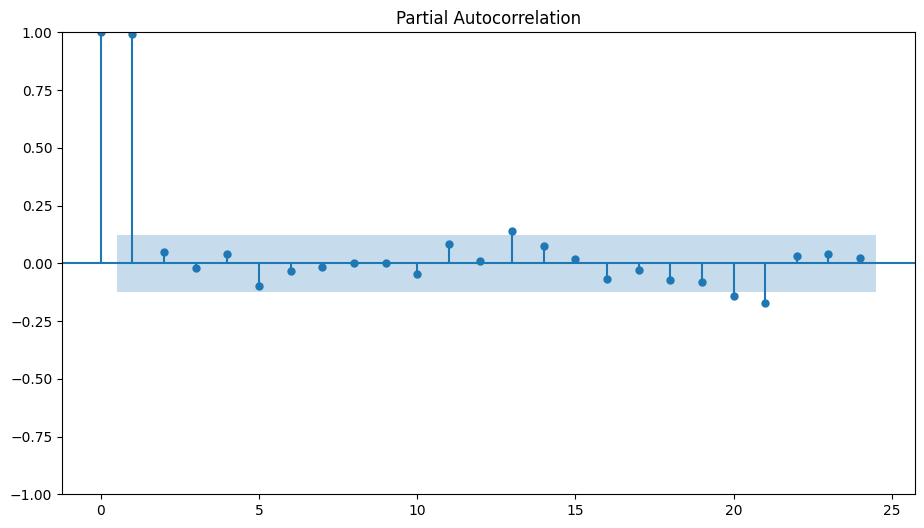

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

ACF가 천천히 감소하고 PACF가 1 번째 시차 이후로 급격히 감소해 0에 수렴하는 AR(자기 회귀) 모형을 보임. 이때 p = 24, q = 1 이지만, ts_log 시계열 자료는 AR 모형의 경향만을 강하게 띈다는 가정 하에 이후 모수 초기값은 p = 24, q = 1로 설정함.

차분 안정성 확인 (d 구하기)

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observatilns Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


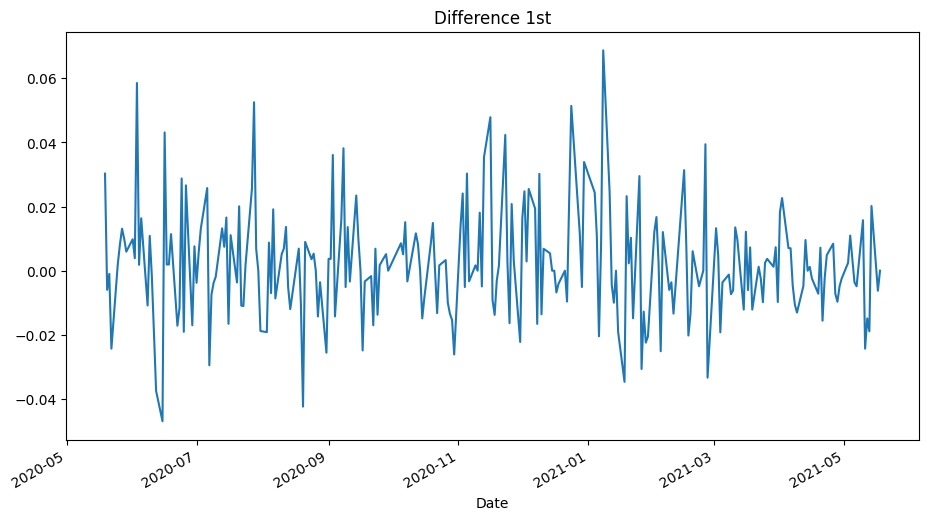

In [40]:
# 1차 차분 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observatilns Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


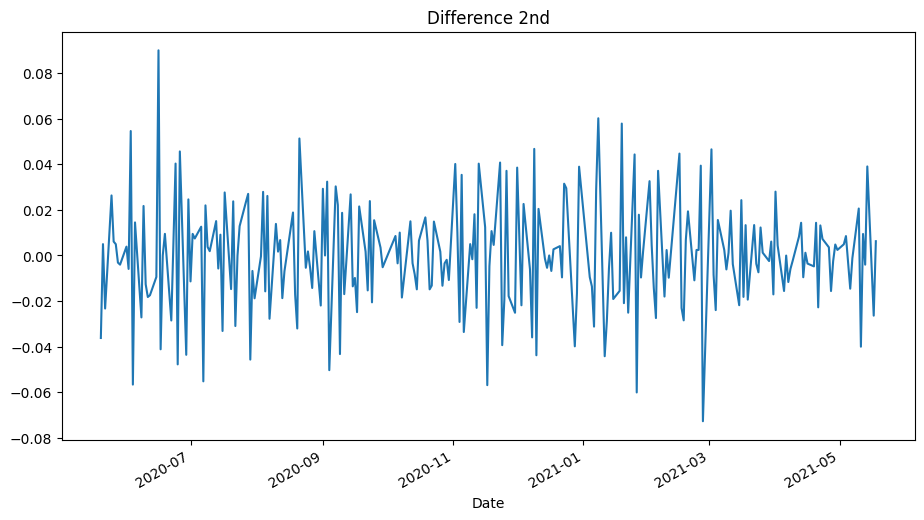

In [43]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")

augmented_dickey_fuller_test(diff_2)

1차 미분 후의 p-value값이 더 작으므로 이후에 d=1로 지정함

# STEP 6 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

__6.1 ARIMA 모델 빌드와 훈련__

In [44]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(24, 1, 0))
fitted_m = model.fit()

print(fitted_m, fitted_m.summary())

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024B1EDAA310>                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(24, 1, 0)   Log Likelihood                 591.679
Date:                Sat, 25 Mar 2023   AIC                          -1133.358
Time:                        00:04:12   BIC                          -1048.067
Sample:                             0   HQIC                         -1098.931
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0410      0.071      0.576      0.565      -0.099       0.180
ar.L2         -0.0162      0.081     -0.200      0.8

__6.2 모델 테스트 및 시각화__

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


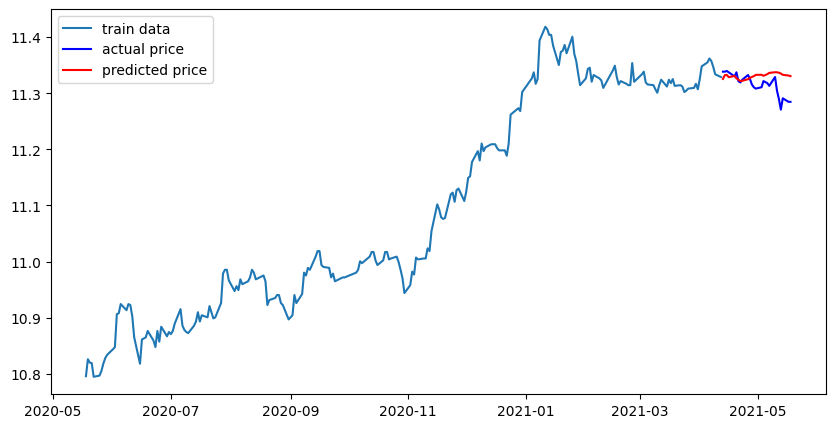

In [45]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# 예측결과(fc) pandas series로 형변환
fc_series = pd.Series(fc, index=test_data.index)

# 시각화
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="train data")
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()


예측 시작 점은 얼추 비슷하나, 뒷부분은 전혀 맞지 않음. ARIMA 모수(파라미터) p, d, q를 조정할 필요가 있어보임.m

__6.3 최종 예측 모델 정확도 측정(MAPE)__

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4443914.185054648
MAE:  1571.0292191144579
RMSE:  2108.059340970896
MAPE: 1.94%


__6.5 ARIMA 모수 최적화 후 테스트 데이터 평가__

In [66]:
model = ARIMA(train_data, order=(27, 0, 15))
fitted_m = model.fit()

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


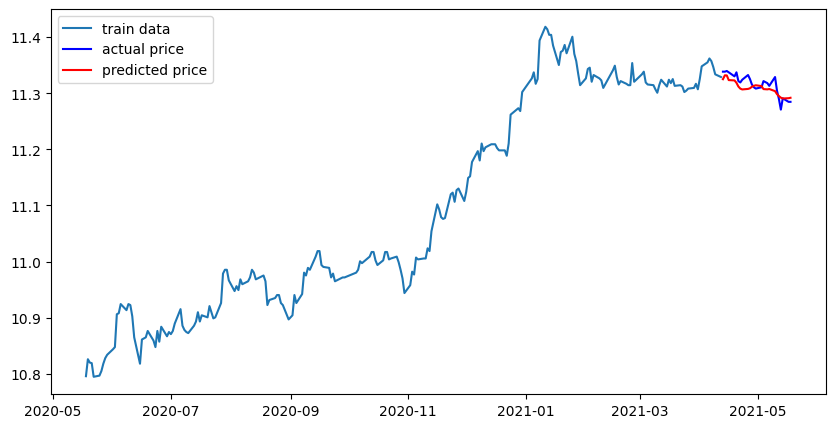

In [67]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# 예측결과(fc) pandas series로 형변환
fc_series = pd.Series(fc, index=test_data.index)

# 시각화
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="train data")
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [68]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1063169.82905959
MAE:  867.343812823568
RMSE:  1031.1012700310237
MAPE: 1.05%


|metrics|모수 최적화 전|모수 최적화 후|
|------|---|---|
|MSE|4443914.185054648|1063169.82905959|
|MAE|1571.0292191144579|867.343812823568|
|RMSE|2108.059340970896|1031.1012700310237|
|MAPE|1.94%|1.05%|

---

# 종목 2 : APPLE

# STEP1 : 시계열 데이터 준비

In [69]:
# Apple 주식 데이터는 Date, Open, High, Low, Close, Adj Close, Volume 총 7 컬럼으로 구성되어 있음
# "Date" 컬럼을 새롭게 Index로 지정해서 파일 불러오기

file_path = './AAPL_6.csv'
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.449394,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.735313,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.314888,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.970070,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.143883,132079200


__1.1 df 데이터 프레임의 'Close' 컬럼을 불러와 시계열 생성__

In [70]:
ts = df['Close']
ts.head()

Date
2020-01-02    75.087502
2020-01-03    74.357498
2020-01-06    74.949997
2020-01-07    74.597504
2020-01-08    75.797501
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

__2.1 결측치 처리__

In [71]:
print(ts.isna().sum())

0


결측치 없음.

__2.2 시계열 안정성(stationary) 여부 시각화를 통해 확인__

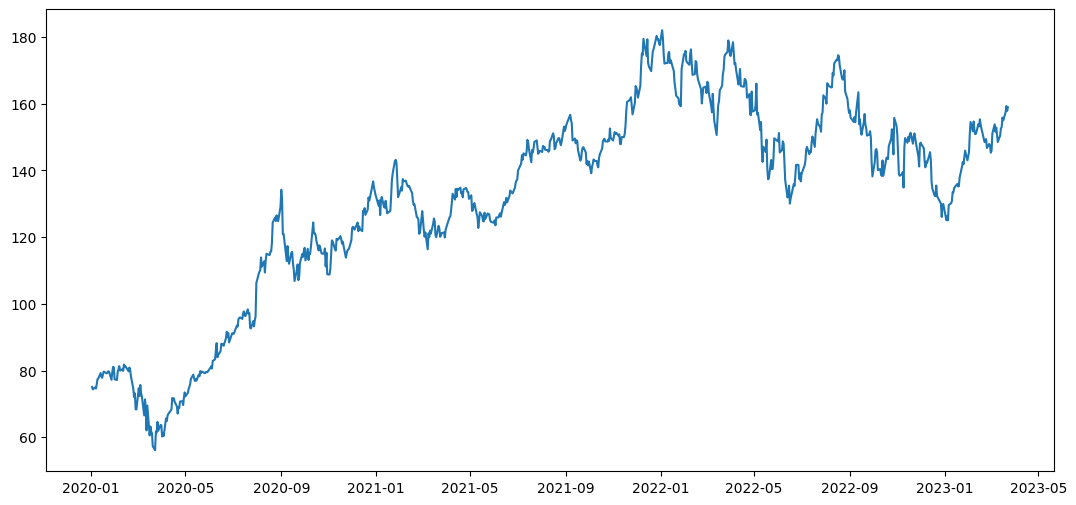

In [72]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기 13,6으로 고정
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

시간 추이에 따른 일정한 평균, 분산, 패턴은 위 그래프 상으로는 보이지 않음

__2.3 로그 변환을 통한 스케일 조정__

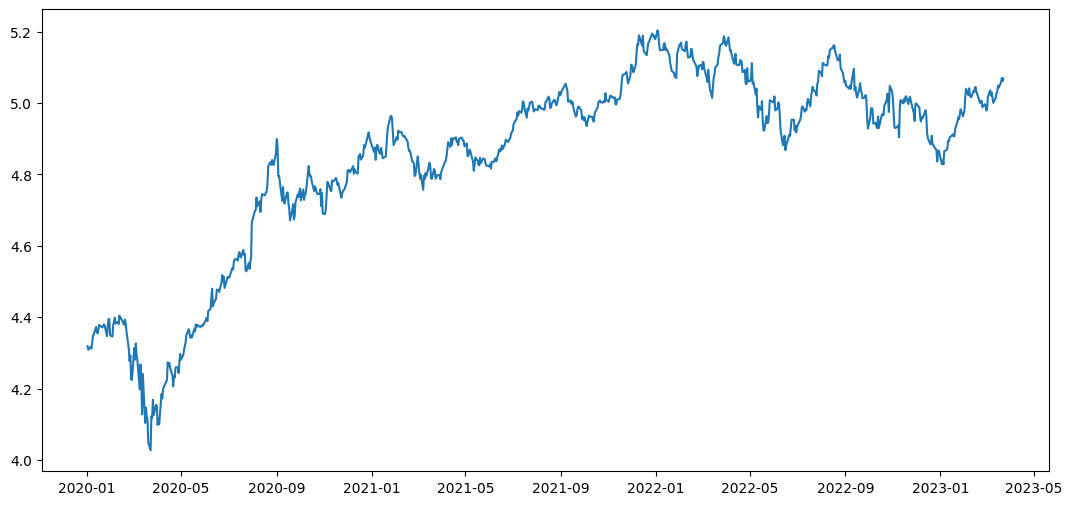

In [73]:
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

__3.1 정성적 그래프 분석_구간 통계치(Rolling Statistics) 시각화 함수 구현__

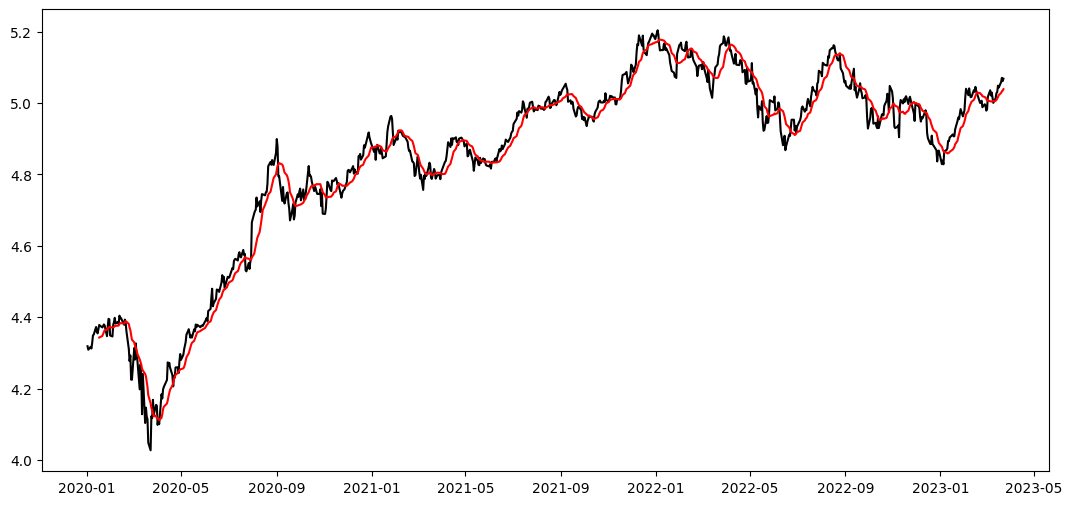

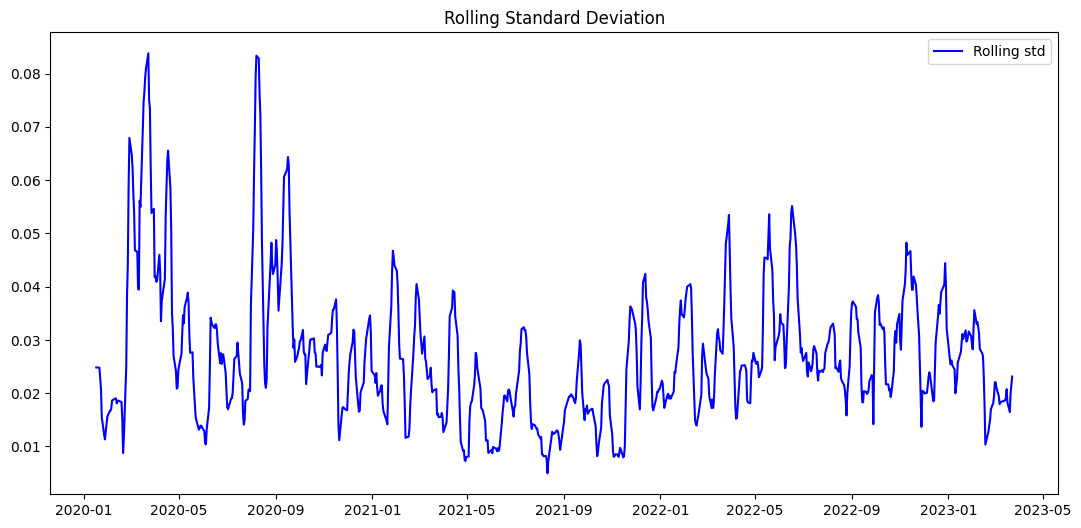

In [74]:
def plot_rolling_statistics(timeseries, window=12):
    
    # Moving averag (이동평균)
    rolmean = timeseries.rolling(window=window).mean() # Moving average
    
    # Moving Standard (이동 표준편차)
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(ts_log, color='black', label='original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    plt.show(block=False)
    std = plt.plot(rolstd, color='blue', label = "Rolling std")
    plt.legend(loc='best')
    plt.title("Rolling Standard Deviation")
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

__3.2 정량적 분석 Augmented Dicky-Fuller Test__ [참고문헌](https://hongl.tistory.com/98)

시계열에 대해 ADF Test를 수행한 후, 결과값으로 나오는 p-value를 통해 정량적으로 stationary한 데이터인지 (0 에 수렴), non-stationary한 데이터인지 확인 (1에 수렴)

In [76]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # ADF test 결과는 리스트와 딕셔너리 타입이 포함된 tuple형태로 나옴.
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 
                                            'Number of Observatilns Used'])
    
    # dftest의 다섯 번째 요소는 dict 타입으로 저장되어 있음. key, value로 나누어 출력
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.782532
p-value                          0.389168
#Lags Used                       9.000000
Number of Observatilns Used    802.000000
Critical Value (1%)             -3.438530
Critical Value (5%)             -2.865151
Critical Value (10%)            -2.568693
dtype: float64


p-value값이 매우 높은것으로 보아 non-stationary한 시계열이라 볼 수 있음

__3.3 시계열 분해(Time Series Decomposition)__

시계열 안에 존재하는 __trend, seasonality__ 분리해주는 seasonal decompose 메서드 활용

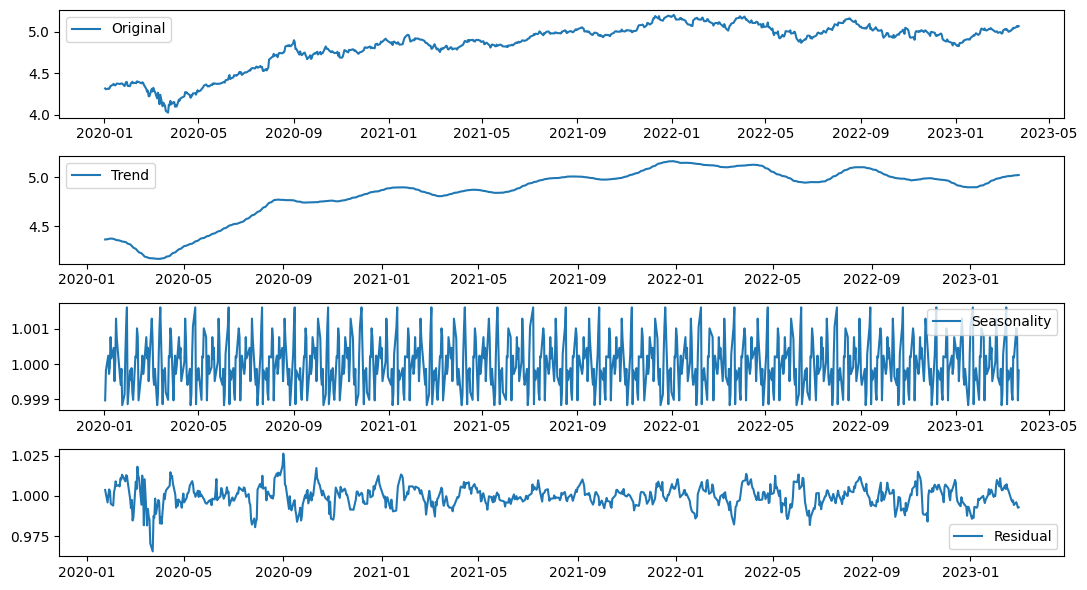

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend # 시간 추이에 따라 나타나는 평균값 변화
seasonality = decomposition.seasonal # 패턴이 파악되지 않은 주기적 변화
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

__3.4 Residual 안정성 확인__

In [78]:
print(residual.isna().sum())

30


In [79]:
residual.shape

(812,)

812개의 행 중, 30개가 결측치를 가짐

In [80]:
residual.dropna(inplace=True)
residual.shape

(782,)

In [81]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.201773e+00
p-value                        7.198652e-13
#Lags Used                     1.900000e+01
Number of Observatilns Used    7.620000e+02
Critical Value (1%)           -3.438961e+00
Critical Value (5%)           -2.865340e+00
Critical Value (10%)          -2.568794e+00
dtype: float64


시계열에서 Trend와 Seasonality를 뺀 Residual의 p값은 매우 작아 stationary 하다고 할 수 있음. 

# STEP 4 : 학습, 테스트 데이터셋 생성

In [82]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

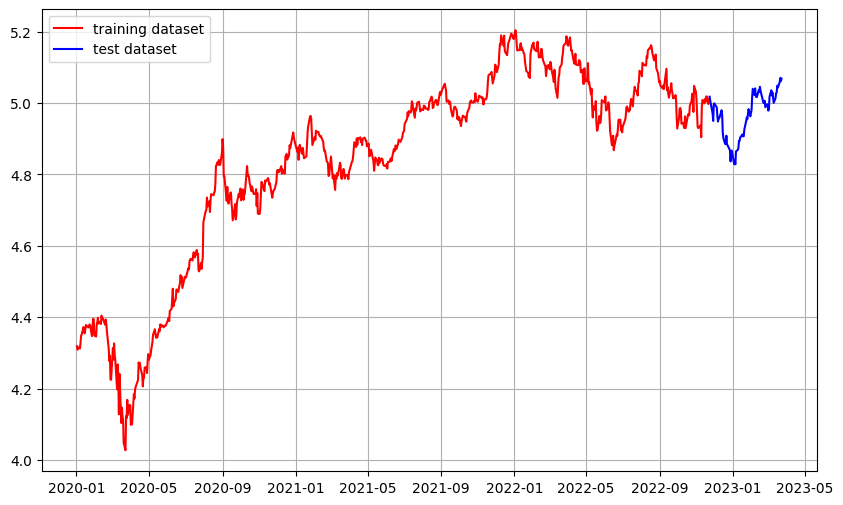

In [83]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r',label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 모수 찾기

__5.1 ACF, PACF 그려서 p,q 구하기__

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


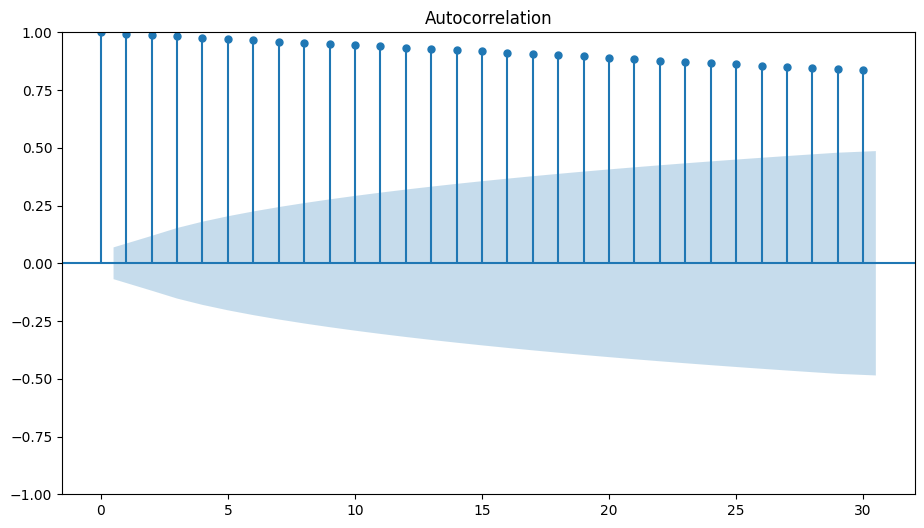

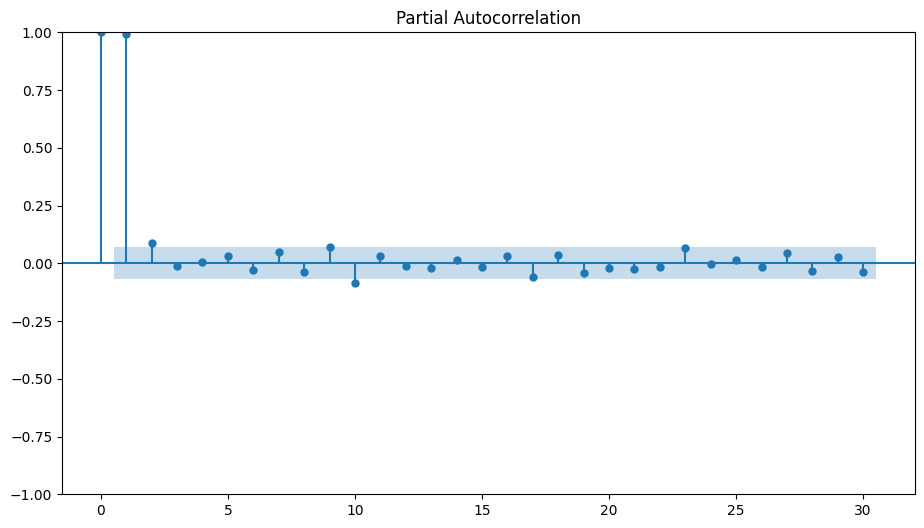

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

* ACF가 천천히 감소하고 PACF가 1 번째 시차 이후로 급격히 감소해 0에 수렴하는 AR(자기 회귀) 모형을 보임. 
* 이때 p값은 위 ACF 그래프상에 나타나지 않아 매우 큰 값일 것으로 예상됨. q = 1 임을 PACF를 통해 알 수 있음, 
* ts_log 시계열 자료는 AR 모형의 경향만을 강하게 띈다는 가정 하에 이후 모수 초기값은 p = 30, q = 1로 설정함.

__5.2 차분 안정성 확인 (d 구하기)__

Results of Dickey-Fuller Test:
Test Statistic                -9.001616e+00
p-value                        6.474554e-15
#Lags Used                     8.000000e+00
Number of Observatilns Used    8.020000e+02
Critical Value (1%)           -3.438530e+00
Critical Value (5%)           -2.865151e+00
Critical Value (10%)          -2.568693e+00
dtype: float64


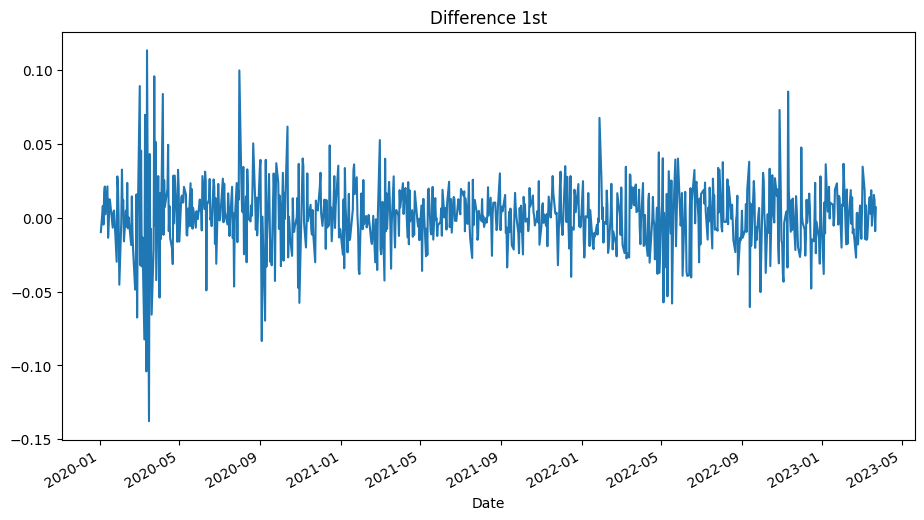

In [85]:
# 1차 차분 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.235363e+01
p-value                        5.751034e-23
#Lags Used                     1.700000e+01
Number of Observatilns Used    7.920000e+02
Critical Value (1%)           -3.438634e+00
Critical Value (5%)           -2.865196e+00
Critical Value (10%)          -2.568717e+00
dtype: float64


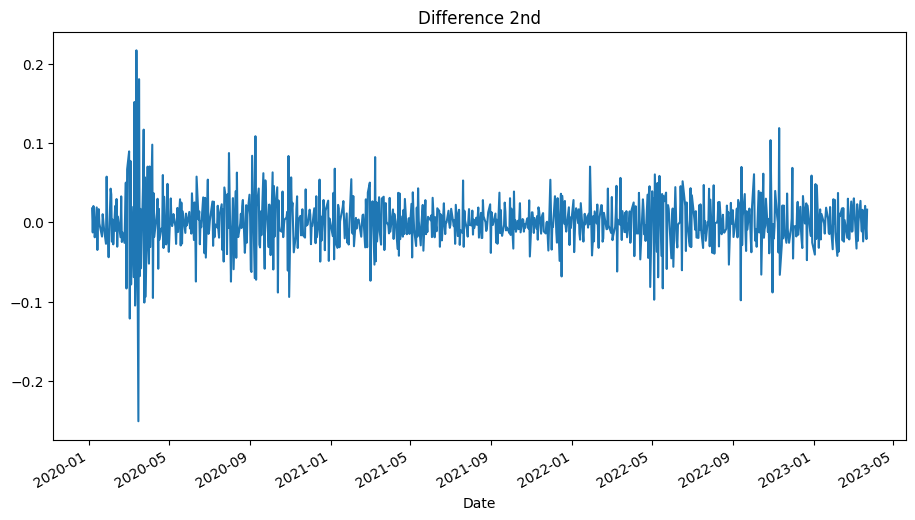

In [86]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")

augmented_dickey_fuller_test(diff_2)

2차 미분 후의 p-value값이 더 작으므로 이후에 d=2로 지정함. 

# STEP 6 : ARIMA 모델 훈련과 테스트

__6.1 ARIMA 모델 빌드와 훈련__

In [87]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(30, 0, 0))
fitted_m = model.fit()

print(fitted_m, fitted_m.summary())

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimiza

<statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024B25D28E50>                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  730
Model:                ARIMA(30, 0, 0)   Log Likelihood                1739.813
Date:                Mon, 27 Mar 2023   AIC                          -3415.627
Time:                        02:25:37   BIC                          -3268.649
Sample:                             0   HQIC                         -3358.922
                                - 730                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7737      0.111     43.068      0.000       4.556       4.991
ar.L1          0.8794      0.033     27.012      0.0

__6.2 모델 테스트 및 시각화__

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


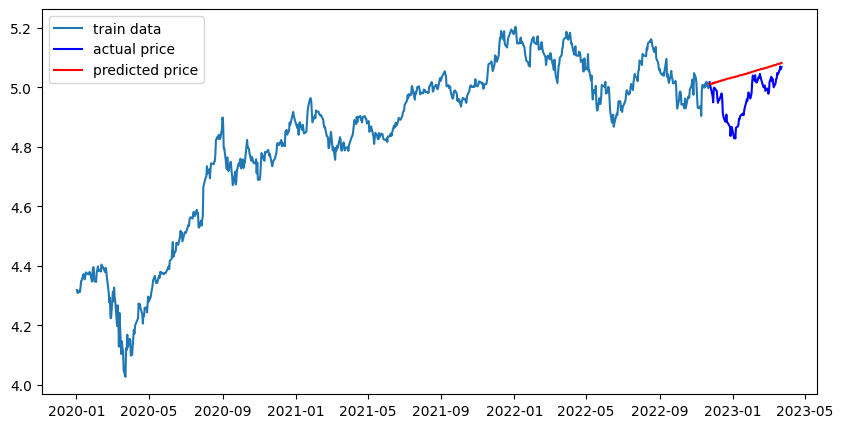

In [90]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# 예측결과(fc) pandas series로 형변환
fc_series = pd.Series(fc, index=test_data.index)

# 시각화
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="train data")
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()


예측 시작 지점은 맞으나, 뒷부분은 전혀 맞지 않음. ARIMA 모수(파라미터) p, d, q를 조정할 필요가 있어보이나, 수차례 테스트한 결과 이 모수의 MAPE 값이 가장 작음

__6.3 최종 예측 모델 정확도 측정(MAPE)__

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  190.18987353062266
MAE:  11.547442071811743
RMSE:  13.790934469085938
MAPE: 8.37%


---

# 종목 3 : Google

In [95]:
file_path = './GOOG.csv'
df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-28,140.684494,141.976501,139.828156,141.949997,141.949997,23774000
2022-03-29,143.160507,144.162506,142.483994,143.250000,143.250000,28678000
2022-03-30,142.869995,143.480499,142.167999,142.644501,142.644501,21046000
2022-03-31,142.448502,142.644501,139.619003,139.649506,139.649506,29516000
2022-04-01,140.009995,140.949997,138.796997,140.699997,140.699997,23480000


__1.1 df 데이터 프레임의 'Close' 컬럼을 불러와 시계열 생성__

In [96]:
ts = df['Close']
ts.head()

Date
2022-03-28    141.949997
2022-03-29    143.250000
2022-03-30    142.644501
2022-03-31    139.649506
2022-04-01    140.699997
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행

__2.1 결측치 처리__

In [97]:
print(ts.isna().sum())

0


__2.2 시계열 안정성(stationary) 여부 시각화를 통해 확인__

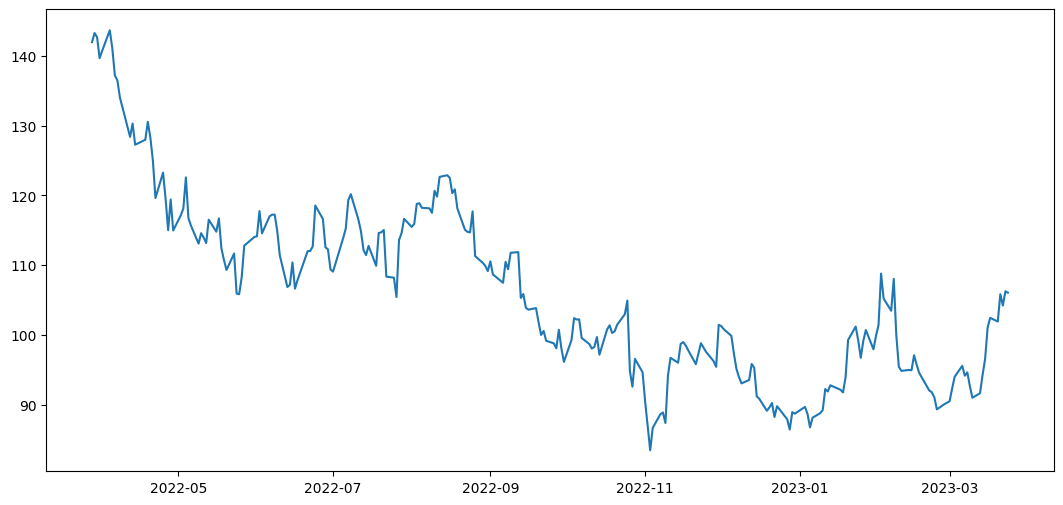

In [98]:
from matplotlib.pylab import rcParams

# matlab 차트의 기본 크기 13,6으로 고정
rcParams['figure.figsize'] = 13, 6

plt.plot(ts)

시간 추이에 따른 일정한 평균, 분산, 패턴은 위 그래프 상으로는 보이지 않음

__2.3 로그 변환을 통한 스케일 조정__

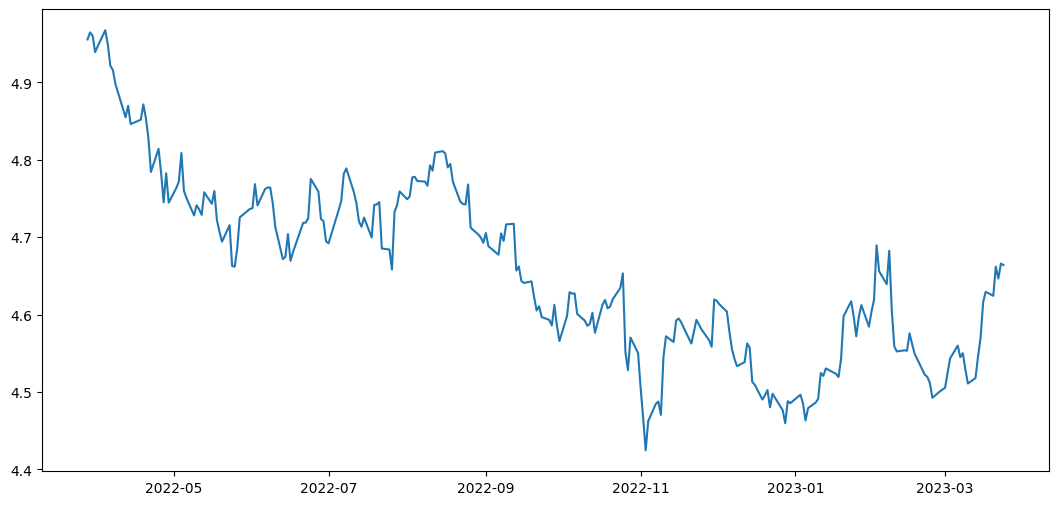

In [99]:
ts_log = np.log(ts)
plt.plot(ts_log)

# STEP 3 : 시계열 안정성 분석

__3.1 정성적 그래프 분석_구간 통계치(Rolling Statistics) 시각화 함수 구현__

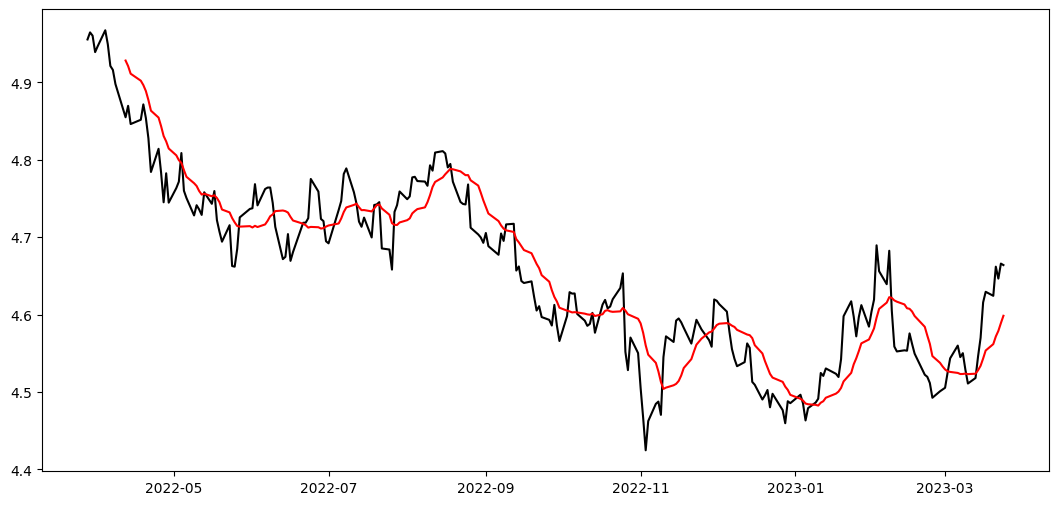

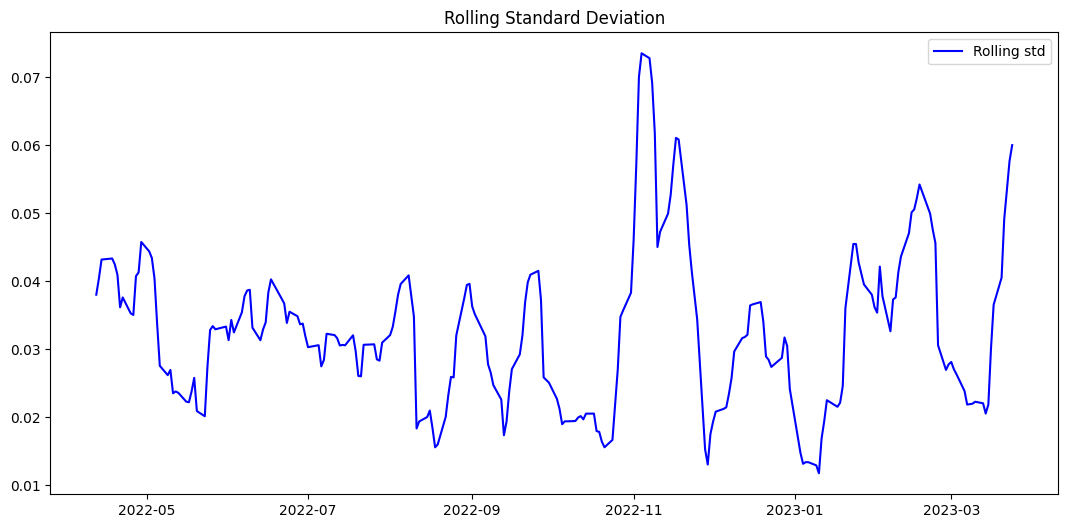

In [102]:
def plot_rolling_statistics(timeseries, window=12):
    
    # Moving averag (이동평균)
    rolmean = timeseries.rolling(window=window).mean() # Moving average
    
    # Moving Standard (이동 표준편차)
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(ts_log, color='black', label='original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    plt.show(block=False)
    std = plt.plot(rolstd, color='blue', label = "Rolling std")
    plt.legend(loc='best')
    plt.title("Rolling Standard Deviation")
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

__3.2 정량적 분석 Augmented Dicky-Fuller Test__

시계열에 대해 ADF Test를 수행한 후, 결과값으로 나오는 p-value를 통해 정량적으로 stationary한 데이터인지 (0 에 수렴), non-stationary한 데이터인지 확인 (1에 수렴)

In [103]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # ADF test 결과는 리스트와 딕셔너리 타입이 포함된 tuple형태로 나옴.
    dftest = adfuller(timeseries, autolag="AIC")
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value',
                                             '#Lags Used', 
                                            'Number of Observatilns Used'])
    
    # dftest의 다섯 번째 요소는 dict 타입으로 저장되어 있음. key, value로 나누어 출력
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.666243
p-value                          0.080064
#Lags Used                       0.000000
Number of Observatilns Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value값이 엄청 높지는 않으나 기준(0.02)에는 못미쳐 non-stationary한 시계열이라 볼 수 있음

__3.3 시계열 분해(Time Series Decomposition)__

시계열 안에 존재하는 __trend, seasonality__ 분리해주는 seasonal decompose 메서드 활용

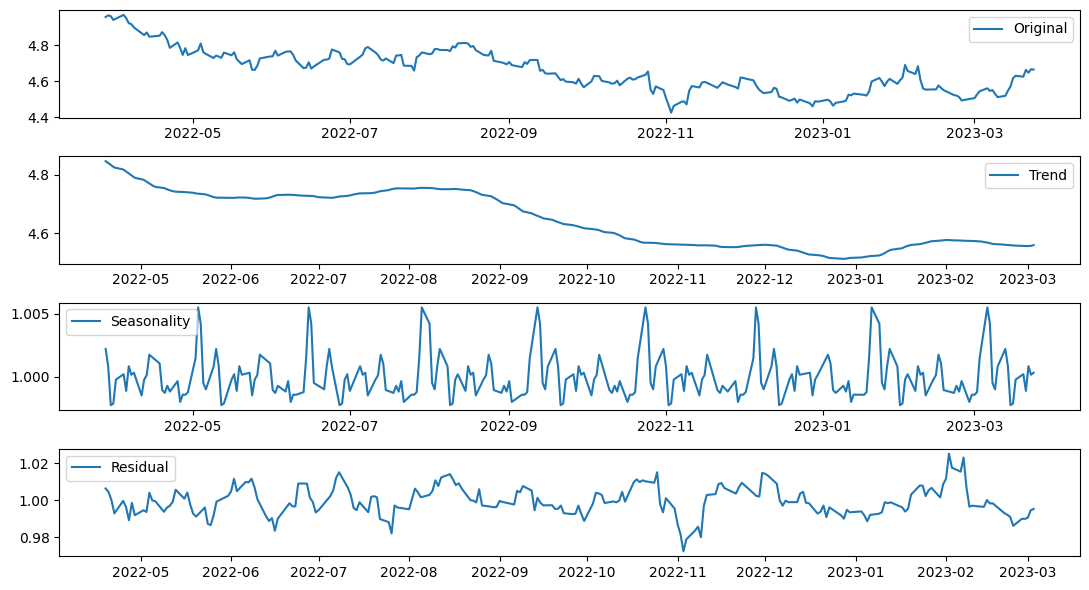

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend # 시간 추이에 따라 나타나는 평균값 변화
seasonality = decomposition.seasonal # 패턴이 파악되지 않은 주기적 변화
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

__3.4 Residual 안정성 확인__

In [105]:
print(residual.isna().sum())

30


In [106]:
residual.shape

(250,)

250개의 행 중, 30개가 결측치를 가짐

In [108]:
residual.dropna(inplace=True)
residual.shape

(220,)

In [109]:
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.126482
p-value                          0.000012
#Lags Used                       0.000000
Number of Observatilns Used    219.000000
Critical Value (1%)             -3.460567
Critical Value (5%)             -2.874830
Critical Value (10%)            -2.573853
dtype: float64


시계열에서 Trend와 Seasonality를 뺀 Residual의 p값은 매우 작아 stationary 하다고 할 수 있음. 

# STEP 4 : 학습, 테스트 데이터셋 생성

In [110]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

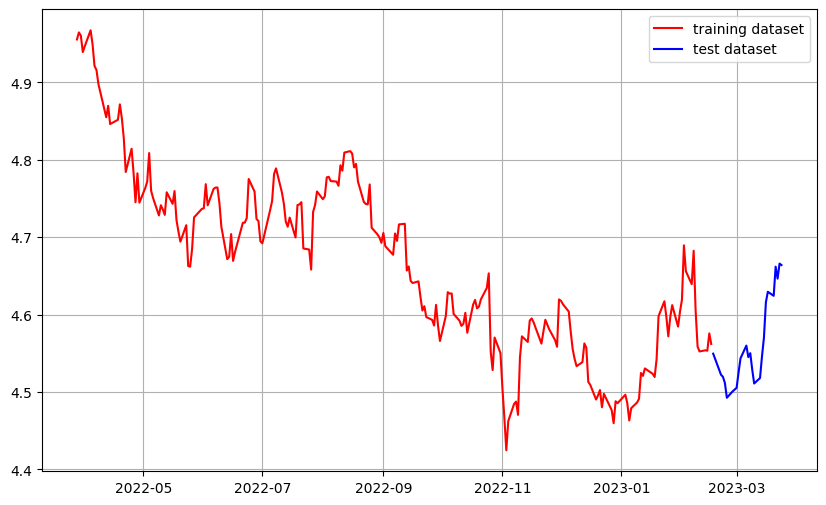

In [111]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(train_data, c='r',label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 모수 찾기

__5.1 ACF, PACF 그려서 p,q 구하기__

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


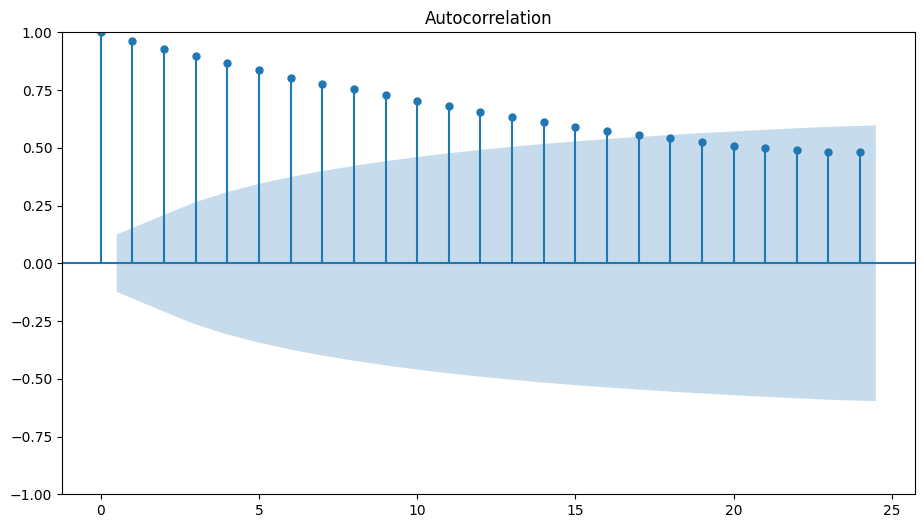

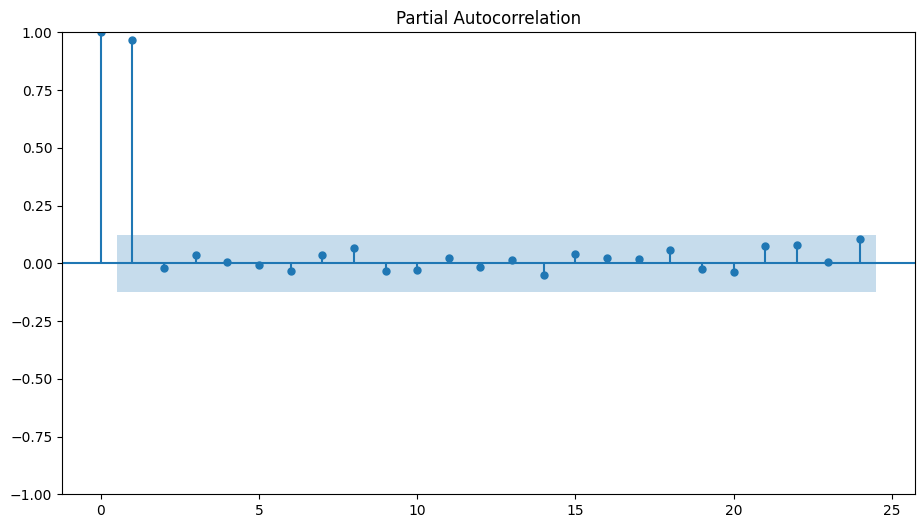

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

* ACF가 천천히 감소하고 PACF가 1 번째 시차 이후로 급격히 감소해 0에 수렴하는 AR(자기 회귀) 모형을 보임. 
* 이때 p값은 위 ACF 그래프 결과로부터 18이고, q = 1 임을 PACF를 통해 알 수 있음, 
* ts_log 시계열 자료는 AR 모형의 경향만을 강하게 띈다는 가정 하에 이후 모수 초기값은 p = 18, q = 1로 설정함.

__5.2 차분 안정성 확인 (d 구하기)__

Results of Dickey-Fuller Test:
Test Statistic                -1.597788e+01
p-value                        6.888094e-29
#Lags Used                     0.000000e+00
Number of Observatilns Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


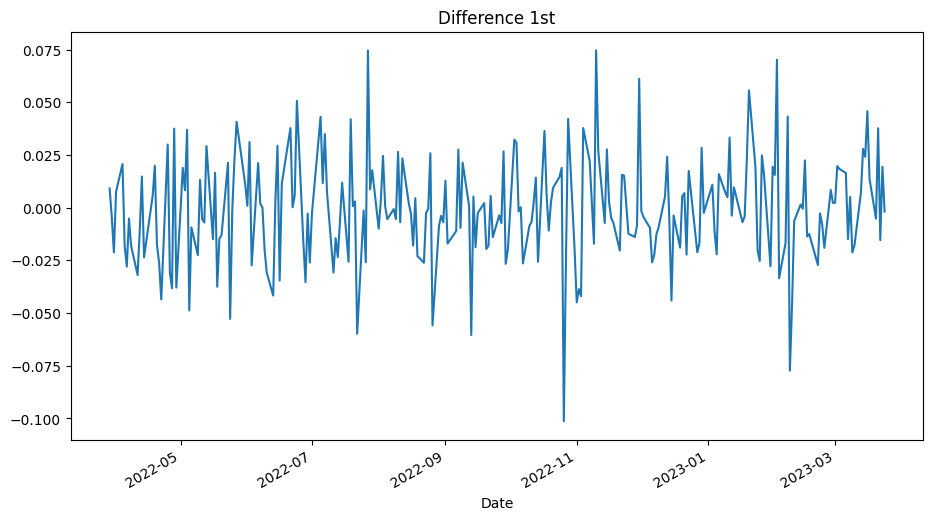

In [113]:
# 1차 차분 
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.438495e+00
p-value                        1.789571e-13
#Lags Used                     1.100000e+01
Number of Observatilns Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


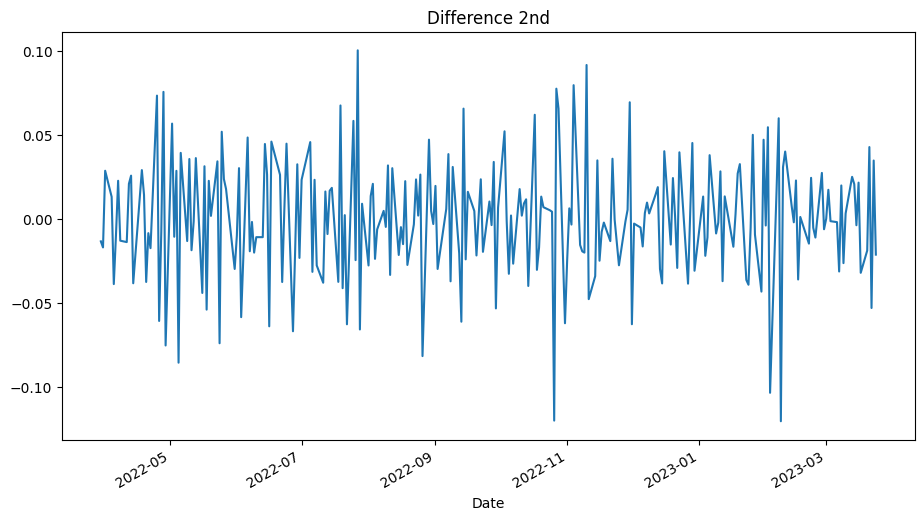

In [114]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")

augmented_dickey_fuller_test(diff_2)

1차 미분 후의 p-value 값이 2차 미분 후 값보다 더 작으므로 이후에 d=1로 지정함. 

# STEP 6 : ARIMA 모델 훈련과 테스트

__6.1 ARIMA 모델 빌드와 훈련__

In [116]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(18, 0, 0))
fitted_m = model.fit()

print(fitted_m, fitted_m.summary())

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x0000024B24AE8F90>                                SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(18, 0, 0)   Log Likelihood                 507.947
Date:                Mon, 27 Mar 2023   AIC                           -975.894
Time:                        02:40:45   BIC                           -907.572
Sample:                             0   HQIC                          -948.319
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7299      0.063     74.802      0.000       4.606       4.854
ar.L1          0.9729      0.073     13.408      0.0

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


__6.2 모델 테스트 및 시각화__

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


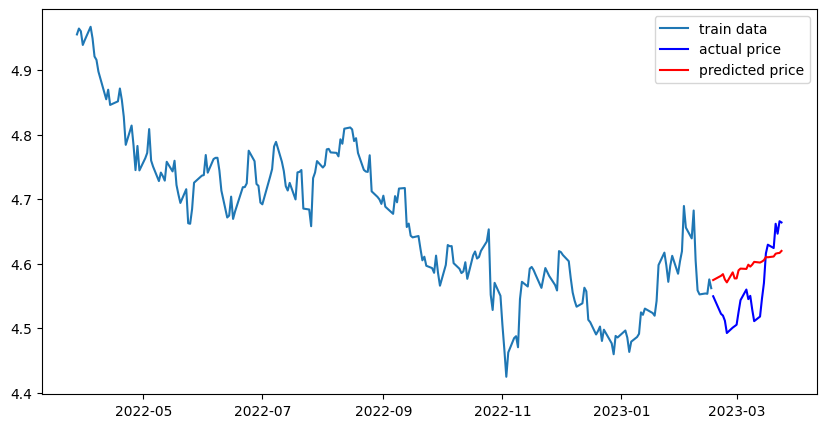

In [117]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# 예측결과(fc) pandas series로 형변환
fc_series = pd.Series(fc, index=test_data.index)

# 시각화
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="train data")
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()


예측 시작 지점과 증가 추세인 것은 맞으나, 중간 예측 결과가 전혀 맞지 않음. ARIMA 모수(파라미터) p, d, q를 조정할 필요가 있어보임.

__6.3 최종 예측 모델 정확도 측정(MAPE)__

In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30.075483132781965
MAE:  5.063678388594707
RMSE:  5.484111881862182
MAPE: 5.39%


__6.5 ARIMA 모수 최적화 후 테스트 데이터 평가__

In [132]:
model = ARIMA(train_data, order=(15, 0, 30))
fitted_m = model.fit()

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

C:\Users\SJang\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


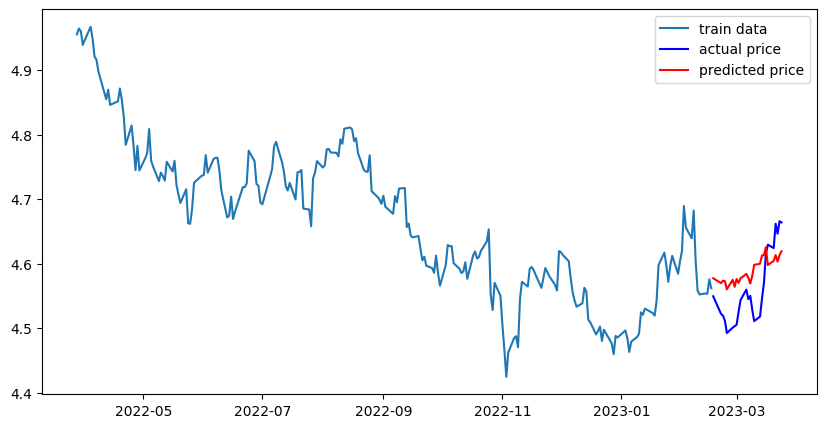

In [133]:
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# 예측결과(fc) pandas series로 형변환
fc_series = pd.Series(fc, index=test_data.index)

# 시각화
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label="train data")
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()


모수 d를 높일수록 예측 결과의 기울기가 음의 값이 됨.

In [134]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mse)
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  24.956581494738597
MAE:  4.637088705891341
RMSE:  4.995656262668459
MAPE: 4.90%


# 회고

1. ACF와 PACF
    * 데이터에서 ACF그래프의 상관계수가 천천히 감소하고 14번째 시차에서 파란 박스 범위 안으로 들어옴. 때문에 모수 q=14 라고 지정할 수 있음.
    * PACF그래프는 1번째 시차 이후로 급격히 감소해 0 근처 값으로 수렴함. 때문에 p=1 이라 지정할 수 있음.
    * ACF의 상관계수가 천천히 감소하고 PACF의 상관계수가 급격히 감소하므로 __AR 모형을 따름__
    * 때문에 모수 p, q, d는 1, 0, d값을 먼저 넣어보는게 맞음. (d 값은 때려넣는 값, 위에서 p + q < 2 & p * d = 0 이라고 했으므로)
    * __그러나__ ACF와 PACF 함수를 통해 선정된 모수 p, q가 무조건 항상 맞는건 아님
    * 결국 최적의 모수를 찾기 위해서는 다 때려넣어보는 수밖에 없음. 때려넣어보는 순서가 있다면,,
        - p, q 값을 서로 바꿔서 넣어보기
        - 시차값을 하나씩 올려보기 정도

2. 의문점(더 공부해야 할 부분)
    * 시계열 분해 중, seasonality의 정의가 "pattern이 파악되지 않은 주기적 변화"라고 하는데 말이 너무 모순적이라 직관적으로 와닿지 않음. 
    * 시계열에서 Trend와 Seasonality를 뺀 Residual의 p값은 매우 작아 stationary 하다고 할 수 있음. 그런데, residual 데이터를 가지고 예측하는게 아닌데 해당 코드가 왜 필요한지 모르겠음
    * 차분 안정성으로 d를 구하는 원리와 이유
    * ARIMA 모델로 피팅 후 나오는 표 해석법

# References

[1] [ADF test](https://hongl.tistory.com/98)<br>
[2] [ARIMA 모형이란?](https://leedakyeong.tistory.com/entry/ARIMA%EB%9E%80-ARIMA-%EB%B6%84%EC%84%9D%EA%B8%B0%EB%B2%95-AR-MA-ACF-PACF-%EC%A0%95%EC%83%81%EC%84%B1%EC%9D%B4%EB%9E%80)<br>
[3] [ARIMA로 비트코인 가격예측](https://byeongkijeong.github.io/ARIMA-with-Python/)<br>
[4] [시계열 분석](http://kanggc.iptime.org/em/chap9/chap9.pdf)<br>
[5] [ADF 파라미터](https://hongl.tistory.com/98)<br>
[6] [Stationary](https://hongl.tistory.com/64)<br>